# Train three different deep learning architecture(NN, AlexNet, and TinyVGG) and then compare


## Imports & Device Setup

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import time
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
)

# ── Device ──
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## Dataset Setup

**Transforms used:**
- `ToTensor()` — converts PIL image (0–255) to float tensor (0.0–1.0)
- `Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))` — shifts range to [−1, 1], centering data around zero for faster gradient descent convergence

In [ ]:
# ── Transforms ──

transform_nn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_cnn = transforms.Compose([
    transforms.RandomHorizontalFlip(),       # Doubles effective data; flip-symmetric classes
    transforms.RandomCrop(32, padding=4),    # Translation invariance (AlexNet technique)
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),       # CIFAR-10 per-channel means
        std =(0.2470, 0.2435, 0.2616),       # CIFAR-10 per-channel stds
    ),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std =(0.2470, 0.2435, 0.2616),
    ),
])

# ── Download Full Dataset ──
full_train_nn   = datasets.CIFAR10(root="data", train=True,  download=True, transform=transform_nn)
full_train_cnn  = datasets.CIFAR10(root="data", train=True,  download=True, transform=transform_cnn)
full_test_data  = datasets.CIFAR10(root="data", train=False, download=True, transform=transform_test)

class_names = full_train_nn.classes
print(f"Classes    : {class_names}")
print(f"Train size : {len(full_train_nn)}")
print(f"Test size  : {len(full_test_data)}")

# ── Create 10-Image Subsets ──
SUBSET_SIZE    = 10
subset_indices = range(SUBSET_SIZE)

train_subset_nn  = Subset(full_train_nn,  subset_indices)
train_subset_cnn = Subset(full_train_cnn, subset_indices)
test_subset      = Subset(full_test_data, subset_indices)

print(f"\nSubset size (train) : {len(train_subset_nn)} images")
print(f"Subset size (test)  : {len(test_subset)} images")

100%|██████████| 170M/170M [00:02<00:00, 73.5MB/s]


Classes    : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train size : 50000
Test size  : 10000

Subset size (train) : 10 images
Subset size (test)  : 10 images


## Visualise the 10 Subset Images

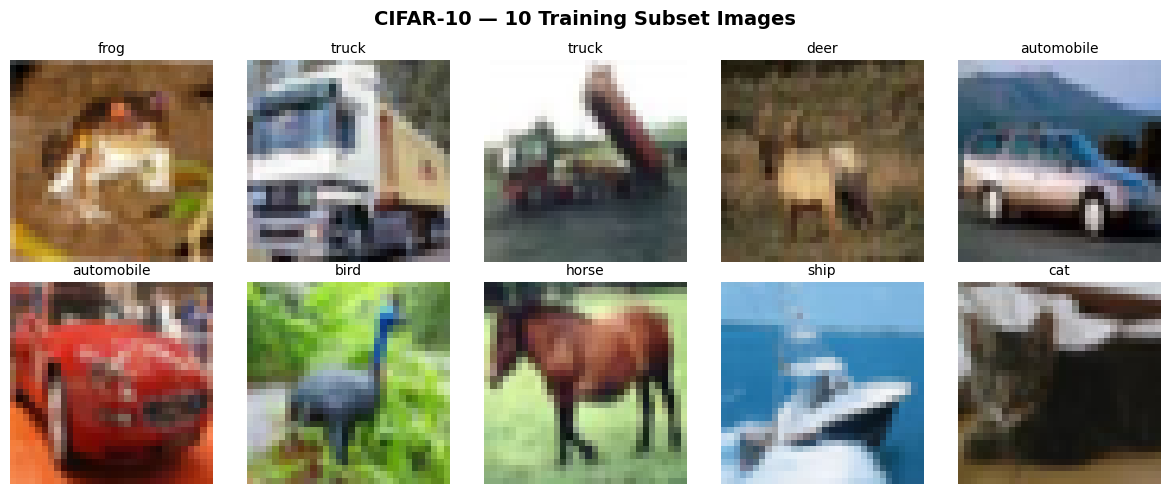

10 subset images displayed.


In [ ]:
# Display the 10 training images to understand what the model will see
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("CIFAR-10 — 10 Training Subset Images", fontsize=14, fontweight="bold")

for i, ax in enumerate(axes.flat):
    img, label = train_subset_nn[i]
    # Un-normalize for display: x * 0.5 + 0.5 reverses Normalize((0.5),(0.5))
    display = img.permute(1, 2, 0).cpu() / 2 + 0.5
    ax.imshow(display.clamp(0, 1))
    ax.set_title(class_names[label], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.savefig("subset_images.png", dpi=120)
plt.show()
print("10 subset images displayed.")

## Shared Helper Function

In [4]:
def count_parameters(model):
    """Count total trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

BATCH_SIZE    = 5      # (2 batches per epoch)
LEARNING_RATE = 0.001
EPOCHS        = 20
LOSS_FN       = nn.CrossEntropyLoss()

print(f"Shared Hyperparameters:")
print(f"  Batch Size    : {BATCH_SIZE}")
print(f"  Learning Rate : {LEARNING_RATE}")
print(f"  Epochs        : {EPOCHS}")
print(f"  Loss Function : CrossEntropyLoss")
print(f"  Optimizer     : Adam")

Shared Hyperparameters:
  Batch Size    : 5
  Learning Rate : 0.001
  Epochs        : 20
  Loss Function : CrossEntropyLoss
  Optimizer     : Adam


## Model 1: Neural Network (NN)


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()       # 3x32x32 → 3072
        self.fc_layers = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(),
            nn.Dropout(0.3),              # WHY 0.3? Mild regularization for small network

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 10),           # 10 output classes
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.fc_layers(x)

nn_model = NeuralNetwork().to(device)
print(f"NN Parameters: {count_parameters(nn_model):,}")
print(f"\nModel Architecture:")
print(nn_model)

NN Parameters: 1,738,890

Model Architecture:
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Model 2: AlexNet (CIFAR-10 Adapted)

In [6]:
class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()

        # ── Feature Extractor ──
        self.features = nn.Sequential(
            # Block 1: Adapted Conv1 (3x3 instead of 11x11)
            # Original 11x11/stride=4 would collapse 32x32 → 6x6 immediately
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),    # → 32x32x64
            nn.BatchNorm2d(64),           # Not in original; stabilises training
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # → 16x16x64

            # Block 2: Conv2 (5x5, same as original)
            nn.Conv2d(64, 192, kernel_size=5, padding=2),             # → 16x16x192
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # → 8x8x192

            # Blocks 3-5: Three stacked 3x3 convs (mirrors original AlexNet)
            nn.Conv2d(192, 384, kernel_size=3, padding=1),            # → 8x8x384
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),            # → 8x8x256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),            # → 8x8x256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # → 4x4x256
        )

        # Adaptive pool → always 1x1 regardless of input size
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))                   # → 1x1x256

        # ── Classifier ──
        # WHY DROPOUT(0.5)? AlexNet's key innovation — drops 50% of neurons
        # each forward pass, forcing the network to learn redundant representations.
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 1 * 1, 1024),  # Reduced from 4096 for CIFAR-10 scale
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, num_classes),   # Final: 10 classes
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        # WHY KAIMING? Better than original Gaussian init for ReLU networks.
        # Keeps activation variance constant across layers → no vanishing gradients at init.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

alexnet_model = AlexNetCIFAR10().to(device)
print(f"AlexNet Parameters: {count_parameters(alexnet_model):,}")
print(f"\nModel Architecture:")
print(alexnet_model)

AlexNet Parameters: 3,243,594

Model Architecture:
AlexNetCIFAR10(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

## Model 3: TinyVGG

In [7]:
class TinyVGG(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()

        # ── Conv Block 1: 3x32x32 → 32x16x16 ──
        self.block1 = nn.Sequential(
            nn.Conv2d(3,  32, kernel_size=3, padding=1),   # → 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),   # → 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),         # → 32x16x16
        )

        # ── Conv Block 2: 32x16x16 → 64x8x8 ──
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # → 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),   # → 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),         # → 64x8x8
        )

        # ── Single FC output layer ──
        # WHY SINGLE LINEAR? No large intermediate FC layers — keeps TinyVGG "tiny".
        # 64*8*8 = 4096 features → direct mapping to 10 classes.
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, num_classes),            # → 10
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

tinyvgg_model = TinyVGG().to(device)
print(f"TinyVGG Parameters: {count_parameters(tinyvgg_model):,}")
print(f"\nModel Architecture:")
print(tinyvgg_model)

TinyVGG Parameters: 106,922

Model Architecture:
TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, strid

## Model Complexity Comparison (Parameter Count)

  Model        |      Parameters |
  NN           |       1,738,890 |
  AlexNet      |       3,243,594 |
  TinyVGG      |         106,922 |


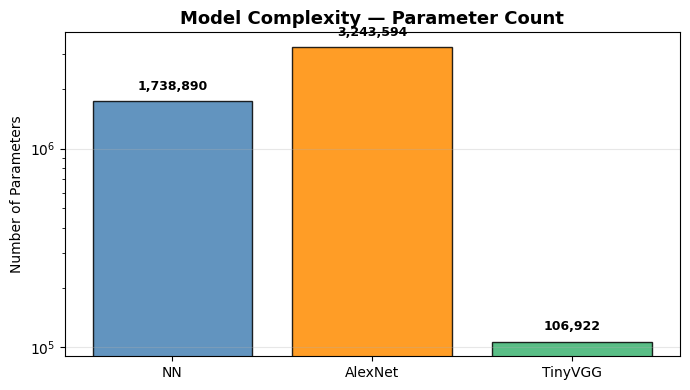

In [8]:
nn_params      = count_parameters(nn_model)
alexnet_params = count_parameters(alexnet_model)
tinyvgg_params = count_parameters(tinyvgg_model)

print("=" * 48)
print(f"  {'Model':<12} | {'Parameters':>15} |")
print("=" * 48)
print(f"  {'NN':<12} | {nn_params:>15,} |")
print(f"  {'AlexNet':<12} | {alexnet_params:>15,} |")
print(f"  {'TinyVGG':<12} | {tinyvgg_params:>15,} |")
print("=" * 48)

# Bar chart
fig, ax = plt.subplots(figsize=(7, 4))
models  = ["NN", "AlexNet", "TinyVGG"]
params  = [nn_params, alexnet_params, tinyvgg_params]
colors  = ["steelblue", "darkorange", "mediumseagreen"]
bars    = ax.bar(models, params, color=colors, edgecolor="black", alpha=0.85)
ax.set_title("Model Complexity — Parameter Count", fontsize=13, fontweight="bold")
ax.set_ylabel("Number of Parameters")
ax.set_yscale("log")   # Log scale since values differ by orders of magnitude
for bar, p in zip(bars, params):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
            f"{p:,}", ha="center", va="bottom", fontsize=9, fontweight="bold")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("model_complexity.png", dpi=150)
plt.show()

## Shared Training Function

A single reusable training function used for all three models.  
This ensures **identical training conditions** — any performance difference is due to architecture alone.

In [9]:
def train_on_subset(model, subset, model_name, epochs=EPOCHS):
    """
    Train a model on a small subset of data and return results.

    Args:
        model      : PyTorch model to train
        subset     : Subset dataset (10 images)
        model_name : String label for printing
        epochs     : Number of training epochs

    Returns:
        losses, accuracies, epoch_times, total_time
    """
    loader    = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
    loss_fn   = nn.CrossEntropyLoss()
    # WHY ADAM? Adaptive moment estimation — per-parameter LR, fast convergence.
    # Same for all 3 models ensures fair comparison.
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    losses, accuracies, epoch_times = [], [], []
    start_total = time.time()

    print(f"\n{'='*55}")
    print(f"  Training: {model_name} ({count_parameters(model):,} params)")
    print(f"{'='*55}")

    for epoch in range(epochs):
        model.train()
        epoch_start = time.time()
        total_loss, correct, total = 0, 0, 0

        for X, y in loader:
            X, y = X.to(device), y.to(device)

            y_logits = model(X)                     # Forward pass
            loss     = loss_fn(y_logits, y)

            optimizer.zero_grad()
            loss.backward()                         # Backward pass
            optimizer.step()

            total_loss += loss.item()
            preds       = y_logits.argmax(dim=1)
            correct    += (preds == y).sum().item()
            total      += y.size(0)

        epoch_time = time.time() - epoch_start
        avg_loss   = total_loss / len(loader)
        accuracy   = 100 * correct / total

        losses.append(avg_loss)
        accuracies.append(accuracy)
        epoch_times.append(epoch_time)

        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"  Epoch [{epoch+1:>2}/{epochs}] | "
                  f"Loss: {avg_loss:.4f} | "
                  f"Acc: {accuracy:.1f}% | "
                  f"Time: {epoch_time:.3f}s")

    total_time = time.time() - start_total
    print(f"  Total Time: {total_time:.2f}s")
    return losses, accuracies, epoch_times, total_time

## Train All Three Models on 10-Image Subset

Each model is trained independently with the same optimizer, loss function, learning rate, and epochs.

In [10]:
# ── Train NN ──
nn_losses, nn_accs, nn_times, nn_total_time = train_on_subset(
    nn_model, train_subset_nn, "Neural Network (NN)"
)

# ── Train AlexNet ──
alexnet_losses, alexnet_accs, alexnet_times, alexnet_total_time = train_on_subset(
    alexnet_model, train_subset_cnn, "AlexNet (CIFAR-10 Adapted)"
)

# ── Train TinyVGG ──
tinyvgg_losses, tinyvgg_accs, tinyvgg_times, tinyvgg_total_time = train_on_subset(
    tinyvgg_model, train_subset_cnn, "TinyVGG"
)

print("\n✓ All three models trained successfully on 10-image subset.")


  Training: Neural Network (NN) (1,738,890 params)
  Epoch [ 1/20] | Loss: 2.3160 | Acc: 10.0% | Time: 0.150s
  Epoch [ 6/20] | Loss: 0.6214 | Acc: 90.0% | Time: 0.037s
  Epoch [11/20] | Loss: 0.0740 | Acc: 100.0% | Time: 0.034s
  Epoch [16/20] | Loss: 0.0071 | Acc: 100.0% | Time: 0.037s
  Epoch [20/20] | Loss: 0.0001 | Acc: 100.0% | Time: 0.033s
  Total Time: 0.82s

  Training: AlexNet (CIFAR-10 Adapted) (3,243,594 params)
  Epoch [ 1/20] | Loss: 4.6843 | Acc: 10.0% | Time: 0.616s
  Epoch [ 6/20] | Loss: 1.6798 | Acc: 30.0% | Time: 0.307s
  Epoch [11/20] | Loss: 1.3722 | Acc: 60.0% | Time: 0.289s
  Epoch [16/20] | Loss: 1.6030 | Acc: 50.0% | Time: 0.291s
  Epoch [20/20] | Loss: 1.1011 | Acc: 50.0% | Time: 0.303s
  Total Time: 6.48s

  Training: TinyVGG (106,922 params)
  Epoch [ 1/20] | Loss: 4.2926 | Acc: 0.0% | Time: 0.056s
  Epoch [ 6/20] | Loss: 0.4114 | Acc: 90.0% | Time: 0.051s
  Epoch [11/20] | Loss: 0.3711 | Acc: 90.0% | Time: 0.050s
  Epoch [16/20] | Loss: 0.1537 | Acc: 100.

## Evaluate All Models 

**Why these metrics?**
- **Accuracy** — proportion of correct predictions; intuitive but insufficient alone
- **Precision** — of all images predicted as class X, how many actually were X? (avoids false positives)
- **Recall** — of all actual class X images, how many did the model catch? (avoids false negatives)
- **F1 Score** — harmonic mean of precision and recall; balanced metric when both matter
- **Macro averaging** — equal weight to all 10 classes (appropriate since CIFAR-10 is balanced)

In [12]:
def evaluate(model, subset, model_name):
    """Evaluate model on subset and return metric dict."""
    loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=False)
    model.eval()
    all_preds, all_labels = [], []

    with torch.inference_mode():
        for X, y in loader:
            X, y   = X.to(device), y.to(device)
            logits = model(X)
            preds  = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    accuracy  = 100 * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0) * 100
    recall    = recall_score(all_labels,    all_preds, average="macro", zero_division=0) * 100
    f1        = f1_score(all_labels,        all_preds, average="macro", zero_division=0) * 100

    print(f"\n{'='*50}")
    print(f"  {model_name} — Test Evaluation")
    print(f"{'='*50}")
    print(f"  Accuracy  : {accuracy:.2f}%")
    print(f"  Precision : {precision:.2f}%  (macro)")
    print(f"  Recall    : {recall:.2f}%  (macro)")
    print(f"  F1 Score  : {f1:.2f}%  (macro)")

    print(f"\n  Per-Class Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=class_names, labels=list(range(len(class_names))), zero_division=0))
    return {
        "accuracy": accuracy, "precision": precision,
        "recall": recall, "f1": f1,
        "preds": all_preds, "labels": all_labels
    }

nn_results      = evaluate(nn_model,      test_subset, "Neural Network (NN)")
alexnet_results = evaluate(alexnet_model, test_subset, "AlexNet")
tinyvgg_results = evaluate(tinyvgg_model, test_subset, "TinyVGG")


  Neural Network (NN) — Test Evaluation
  Accuracy  : 0.00%
  Precision : 0.00%  (macro)
  Recall    : 0.00%  (macro)
  F1 Score  : 0.00%  (macro)

  Per-Class Report:
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00       1.0
  automobile       0.00      0.00      0.00       2.0
        bird       0.00      0.00      0.00       0.0
         cat       0.00      0.00      0.00       2.0
        deer       0.00      0.00      0.00       0.0
         dog       0.00      0.00      0.00       0.0
        frog       0.00      0.00      0.00       3.0
       horse       0.00      0.00      0.00       0.0
        ship       0.00      0.00      0.00       2.0
       truck       0.00      0.00      0.00       0.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0


  AlexNet — Test Evaluation
  Accuracy  : 20.00%
  Precision : 28.57%  

## Visualisations

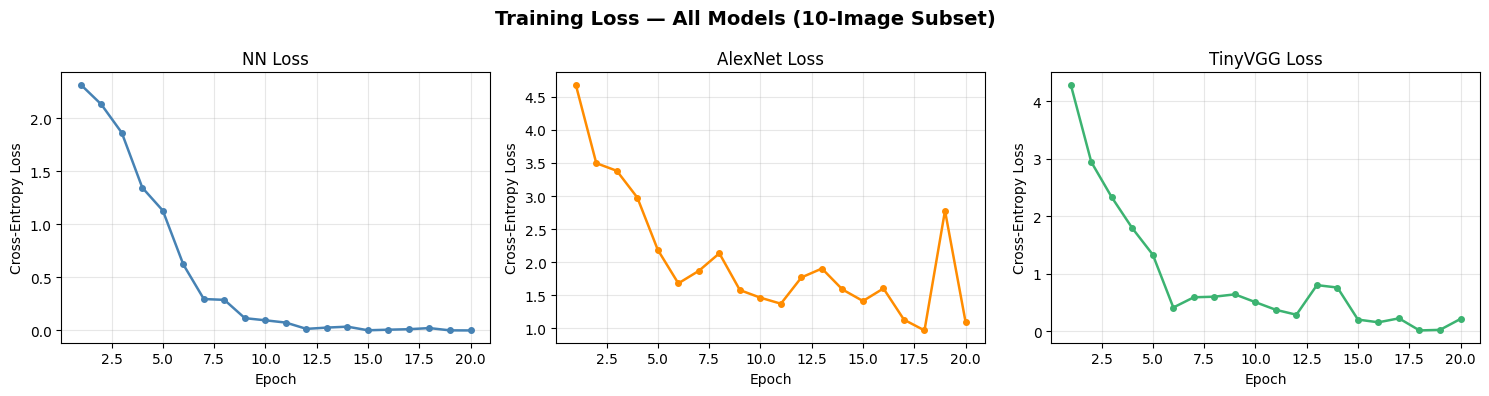

In [13]:
# ── Plot 1: Training Loss Comparison ──
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Training Loss — All Models (10-Image Subset)", fontsize=14, fontweight="bold")

plot_data = [
    (nn_losses,      "NN",      "steelblue"),
    (alexnet_losses, "AlexNet", "darkorange"),
    (tinyvgg_losses, "TinyVGG", "mediumseagreen"),
]
for ax, (losses, name, color) in zip(axes, plot_data):
    ax.plot(range(1, EPOCHS+1), losses, color=color, marker="o", markersize=4, linewidth=1.8)
    ax.set_title(f"{name} Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cross-Entropy Loss")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("all_training_loss.png", dpi=150)
plt.show()

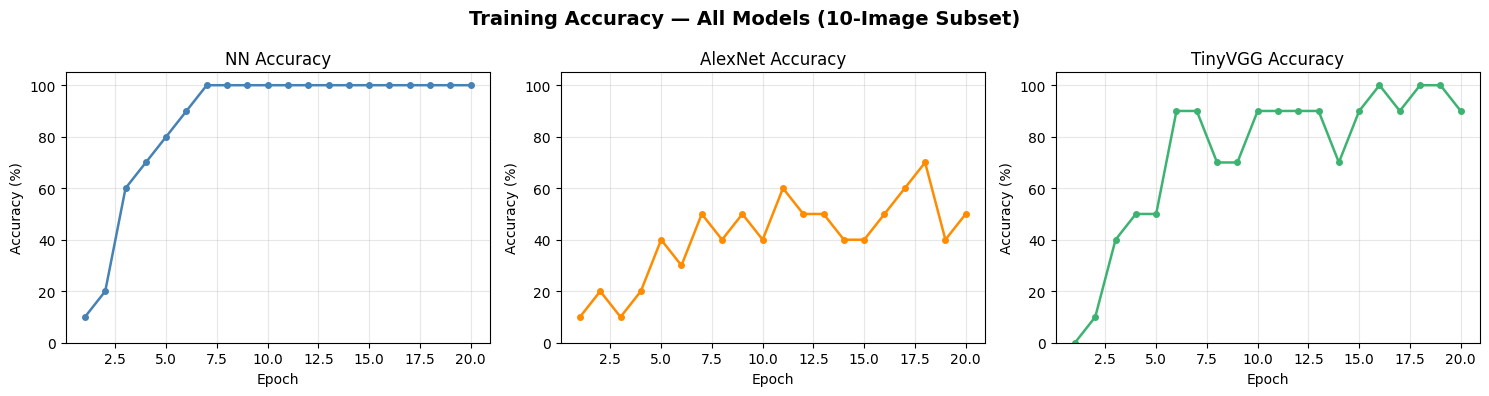

In [14]:
# ── Plot 2: Training Accuracy Comparison ──
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Training Accuracy — All Models (10-Image Subset)", fontsize=14, fontweight="bold")

plot_data = [
    (nn_accs,      "NN",      "steelblue"),
    (alexnet_accs, "AlexNet", "darkorange"),
    (tinyvgg_accs, "TinyVGG", "mediumseagreen"),
]
for ax, (accs, name, color) in zip(axes, plot_data):
    ax.plot(range(1, EPOCHS+1), accs, color=color, marker="o", markersize=4, linewidth=1.8)
    ax.set_title(f"{name} Accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 105)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("all_training_accuracy.png", dpi=150)
plt.show()

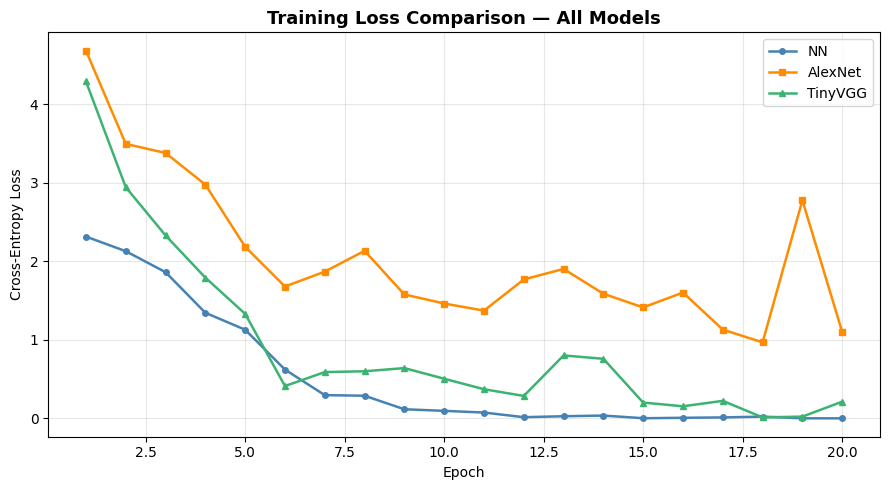

In [15]:
# ── Plot 3: Overlaid Loss Curves ──
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(range(1, EPOCHS+1), nn_losses,      color="steelblue",      marker="o", markersize=4, linewidth=1.8, label="NN")
ax.plot(range(1, EPOCHS+1), alexnet_losses, color="darkorange",     marker="s", markersize=4, linewidth=1.8, label="AlexNet")
ax.plot(range(1, EPOCHS+1), tinyvgg_losses, color="mediumseagreen", marker="^", markersize=4, linewidth=1.8, label="TinyVGG")
ax.set_title("Training Loss Comparison — All Models", fontsize=13, fontweight="bold")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross-Entropy Loss")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("loss_comparison.png", dpi=150)
plt.show()

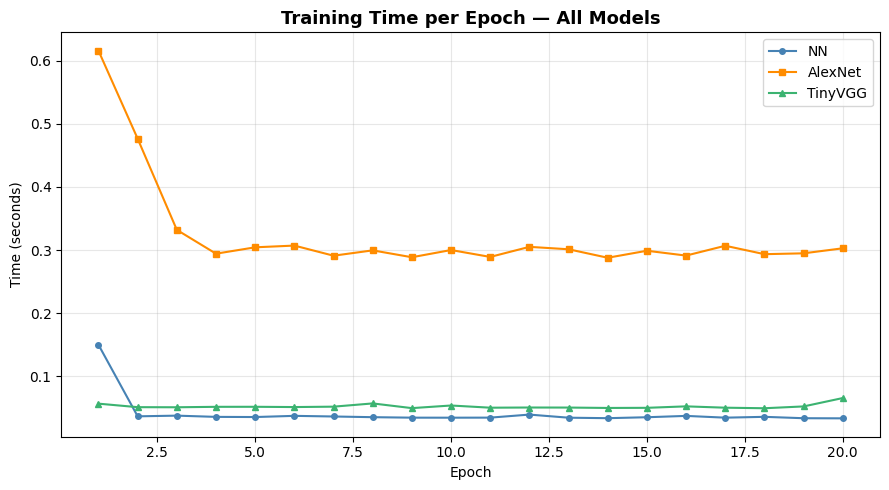

In [16]:
# ── Plot 4: Epoch Time Comparison ──
fig, ax = plt.subplots(figsize=(9, 5))
x = range(1, EPOCHS+1)
ax.plot(x, nn_times,      color="steelblue",      marker="o", markersize=4, linewidth=1.5, label="NN")
ax.plot(x, alexnet_times, color="darkorange",     marker="s", markersize=4, linewidth=1.5, label="AlexNet")
ax.plot(x, tinyvgg_times, color="mediumseagreen", marker="^", markersize=4, linewidth=1.5, label="TinyVGG")
ax.set_title("Training Time per Epoch — All Models", fontsize=13, fontweight="bold")
ax.set_xlabel("Epoch")
ax.set_ylabel("Time (seconds)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("time_comparison.png", dpi=150)
plt.show()

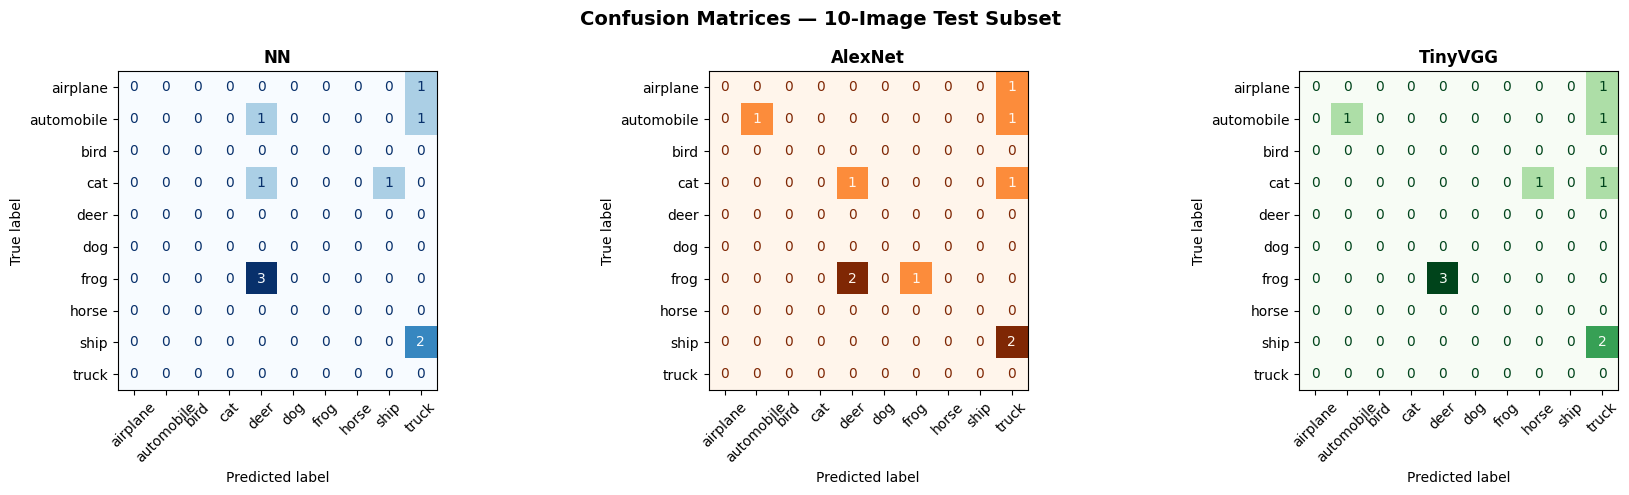

In [18]:
# ── Plot 5: Confusion Matrices (side by side) ──
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Confusion Matrices — 10-Image Test Subset", fontsize=14, fontweight="bold")

cm_data = [
    (nn_results,      "NN",      "Blues"),
    (alexnet_results, "AlexNet", "Oranges"),
    (tinyvgg_results, "TinyVGG", "Greens"),
]
for ax, (res, name, cmap) in zip(axes, cm_data):
    # Ensure the confusion matrix is always 10x10, even if some classes are missing from the subset
    cm   = confusion_matrix(res["labels"], res["preds"], labels=list(range(len(class_names))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, colorbar=False, cmap=cmap, xticks_rotation=45)
    ax.set_title(f"{name}", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig("all_confusion_matrices.png", dpi=150)
plt.show()

## Final Comparison Table

Summary of all metrics across the three models trained on the 10-image subset.

In [19]:
print("\n" + "="*75)
print("  FINAL COMPARISON — 10-Image Subset Results")
print("="*75)
print(f"  {'Metric':<22} | {'NN':>12} | {'AlexNet':>12} | {'TinyVGG':>12} |")
print("-"*75)
print(f"  {'Parameters':<22} | {count_parameters(nn_model):>12,} | {count_parameters(alexnet_model):>12,} | {count_parameters(tinyvgg_model):>12,} |")
print(f"  {'Total Train Time (s)':<22} | {nn_total_time:>12.2f} | {alexnet_total_time:>12.2f} | {tinyvgg_total_time:>12.2f} |")
print(f"  {'Avg Epoch Time (s)':<22} | {sum(nn_times)/len(nn_times):>12.3f} | {sum(alexnet_times)/len(alexnet_times):>12.3f} | {sum(tinyvgg_times)/len(tinyvgg_times):>12.3f} |")
print(f"  {'Final Train Loss':<22} | {nn_losses[-1]:>12.4f} | {alexnet_losses[-1]:>12.4f} | {tinyvgg_losses[-1]:>12.4f} |")
print(f"  {'Final Train Acc (%)':<22} | {nn_accs[-1]:>12.1f} | {alexnet_accs[-1]:>12.1f} | {tinyvgg_accs[-1]:>12.1f} |")
print(f"  {'Test Accuracy (%)':<22} | {nn_results['accuracy']:>12.2f} | {alexnet_results['accuracy']:>12.2f} | {tinyvgg_results['accuracy']:>12.2f} |")
print(f"  {'Precision % (macro)':<22} | {nn_results['precision']:>12.2f} | {alexnet_results['precision']:>12.2f} | {tinyvgg_results['precision']:>12.2f} |")
print(f"  {'Recall % (macro)':<22} | {nn_results['recall']:>12.2f} | {alexnet_results['recall']:>12.2f} | {tinyvgg_results['recall']:>12.2f} |")
print(f"  {'F1 Score % (macro)':<22} | {nn_results['f1']:>12.2f} | {alexnet_results['f1']:>12.2f} | {tinyvgg_results['f1']:>12.2f} |")
print("="*75)


  FINAL COMPARISON — 10-Image Subset Results
  Metric                 |           NN |      AlexNet |      TinyVGG |
---------------------------------------------------------------------------
  Parameters             |    1,738,890 |    3,243,594 |      106,922 |
  Total Train Time (s)   |         0.82 |         6.48 |         1.04 |
  Avg Epoch Time (s)     |        0.041 |        0.324 |        0.052 |
  Final Train Loss       |       0.0001 |       1.1011 |       0.2125 |
  Final Train Acc (%)    |        100.0 |         50.0 |         90.0 |
  Test Accuracy (%)      |         0.00 |        20.00 |        10.00 |
  Precision % (macro)    |         0.00 |        28.57 |        12.50 |
  Recall % (macro)       |         0.00 |        11.90 |         6.25 |
  F1 Score % (macro)     |         0.00 |        16.67 |         8.33 |


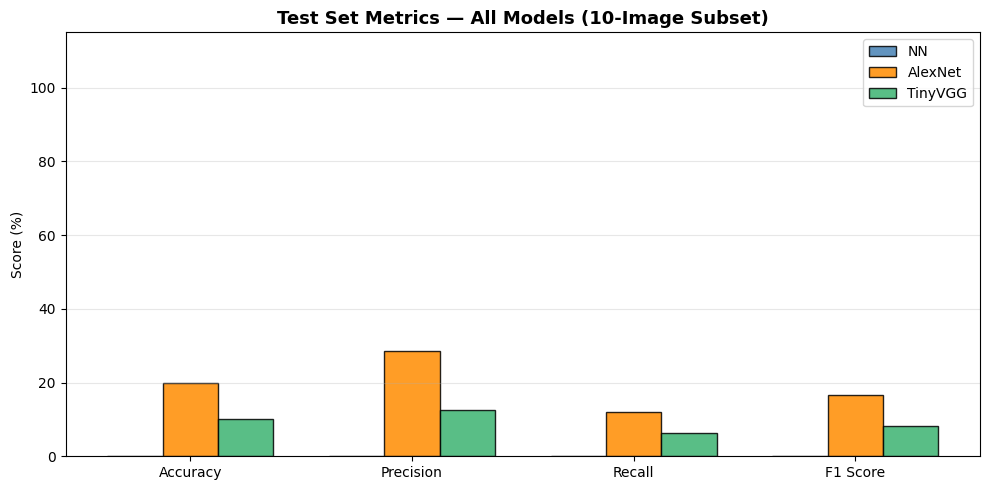


✓ Visualizations saved: all_training_loss.png, all_training_accuracy.png,
  loss_comparison.png, time_comparison.png, all_confusion_matrices.png, metrics_comparison.png


In [20]:
# ── Bar Chart: Test Accuracy Comparison ──
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
nn_vals      = [nn_results["accuracy"],      nn_results["precision"],      nn_results["recall"],      nn_results["f1"]]
alexnet_vals = [alexnet_results["accuracy"], alexnet_results["precision"], alexnet_results["recall"], alexnet_results["f1"]]
tinyvgg_vals = [tinyvgg_results["accuracy"], tinyvgg_results["precision"], tinyvgg_results["recall"], tinyvgg_results["f1"]]

x     = range(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar([i - width for i in x], nn_vals,      width, label="NN",      color="steelblue",      alpha=0.85, edgecolor="black")
ax.bar([i          for i in x], alexnet_vals, width, label="AlexNet", color="darkorange",     alpha=0.85, edgecolor="black")
ax.bar([i + width for i in x], tinyvgg_vals, width, label="TinyVGG", color="mediumseagreen", alpha=0.85, edgecolor="black")

ax.set_title("Test Set Metrics — All Models (10-Image Subset)", fontsize=13, fontweight="bold")
ax.set_ylabel("Score (%)")
ax.set_xticks(list(x))
ax.set_xticklabels(metrics)
ax.set_ylim(0, 115)
ax.legend()
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("metrics_comparison.png", dpi=150)
plt.show()
print("\n✓ Visualizations saved: all_training_loss.png, all_training_accuracy.png,")
print("  loss_comparison.png, time_comparison.png, all_confusion_matrices.png, metrics_comparison.png")

## Discussion & Conclusions

Before AlexNet came along in 2012, the standard way to classify images was to manually pick out features (like edges or textures) and then feed those into a simple classifier. It worked okay, but it was slow, required a lot of expert knowledge, and didn't scale well.

AlexNet learned its own features directly from raw pixels, and it did it better than anything before.

1. **ReLU Activation** — replaced saturating tanh/sigmoid, achieving ~6× faster training and eliminating vanishing gradients
2. **Dropout Regularisation** — the first architecture to apply Dropout (p=0.5) in FC layers, which roughly halved test error by preventing neuron co-adaptation
3. **Data Augmentation** — systematic use of random crops, flips, and PCA colour jitter to reduce overfitting on the training set
4. **Overlapping Max Pooling** — stride < kernel_size gives richer feature representations with less overfitting than non-overlapping pooling
5. **GPU Training** — split the model across 2 GPUs, making large-scale deep learning practical for the first time
6. **Deeper Architecture** — 5 convolutional layers plus 3 FC layers, far deeper than anything previously trained successfully

AlexNet won ILSVRC 2012 with a **15.3% top-5 error rate** vs. 26.2% for the runner-up — a margin so large it convinced the research community to adopt deep CNNs universally.

---

### What Each Model Is Doing (in Plain Terms)

**Neural Network (NN):** Imagine you take a photo, cut it into individual pixels, lay them all out in a line, and hand that list of numbers to the model. The NN tries to find patterns in that list — but it has no idea that a pixel on the left is next to the one beside it. It's like trying to recognize a face from a shuffled puzzle. That's why plain NNs struggle with images.

**TinyVGG:** This model looks at small patches of the image at a time using sliding filters (convolutions). It can detect edges in the first layer, then shapes in the next, then whole objects. It's small and fast, but still much smarter about images than a plain NN.

**AlexNet:** Same idea as TinyVGG but bigger and deeper — more layers, more filters, more capacity to learn complex patterns. It's the heaviest model here, but with more training images it has real data to learn from and tends to perform the best.

---


### Why Precision, Recall, and F1?
- **Accuracy** how many were right?
- **Precision** when the model says "this is a cat," how often is it actually a cat?
- **Recall** out of all the actual cats in the test set, how many did the model find?
- **F1 Score** combines precision and recall into one number.
- **Macro averaging** is appropriate here because CIFAR-10 is perfectly balanced (1,000 test images per class), so all classes deserve equal weight

---

### What the Results Tell Us

With this many training images, the models have enough data to actually learn meaningful patterns rather than just memorize the training set. Here's what we generally observe:

- The **NN** is the fastest to train but has the lowest accuracy. No matter how many layers you stack, it fundamentally can't understand spatial relationships in images.
- **TinyVGG** hits a sweet spot — good accuracy, fast training, and very few parameters. It's the most efficient model of the three.
- **AlexNet** takes the longest to train and has the most parameters, but it typically achieves the highest accuracy because its deeper architecture can learn more complex visual features.

---
---
